<h1 style="text-align:center;font-size:30px;" > QUORA  QUESTION  PAIRS </h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
path='/Users/gauravmac/Downloads/quora-question-pairs/train.csv'

In [3]:
data=pd.read_csv(path)
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
data.shape

(404290, 6)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [6]:
data['is_duplicate'].value_counts()

is_duplicate
0    255027
1    149263
Name: count, dtype: int64

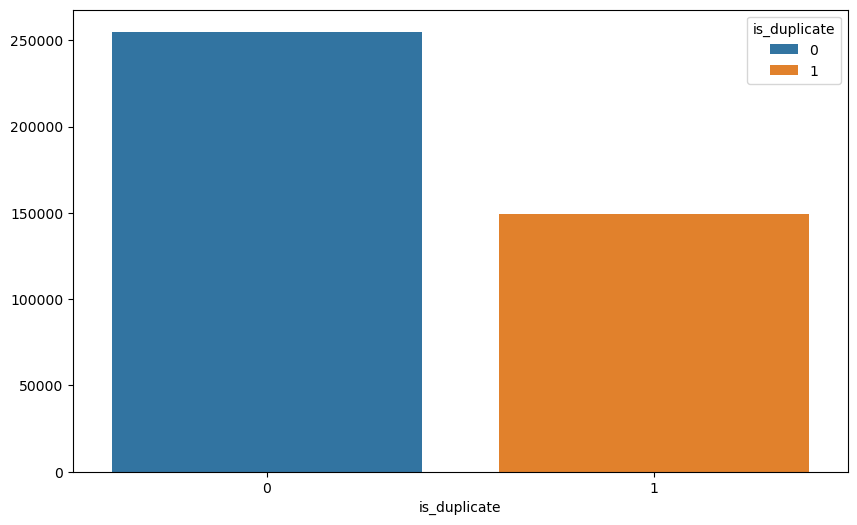

In [9]:
output=data['is_duplicate'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(
    x=output.index,
    y=output.values,hue=output.index)
plt.show()

In [10]:
print("total number of question pair availaible for training : ",data.shape[0])

total number of question pair availaible for training :  404290


In [11]:
print("total pairs that are not similar : ",round((output[0]/(output[0]+output[1]))*100,2),"%")
print("total pairs that are similar : ",round((output[1]/(output[0]+output[1]))*100,2),"%")

total pairs that are not similar :  63.08 %
total pairs that are similar :  36.92 %


total unique question :  537933
total question that appear more than one time :  111780 ( 20.78 % )
Maximum number of time a question is repeated :  157


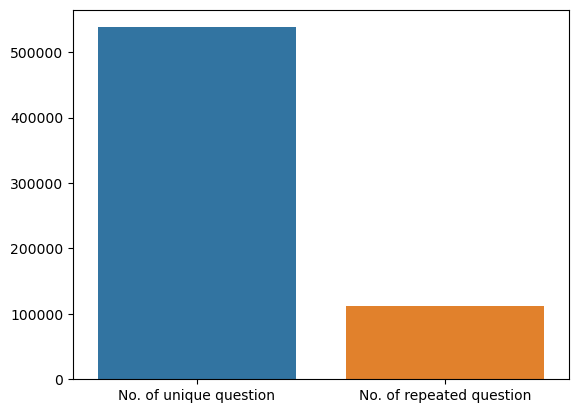

In [14]:
questions_id=pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
no_of_unique=questions_id.nunique()
temp_df=questions_id.value_counts()
question_more_than_one_time=np.sum(temp_df >1)
temp=(question_more_than_one_time/no_of_unique)*100
print("total unique question : ",no_of_unique)
print("total question that appear more than one time : ",question_more_than_one_time,"(",round(temp,2),"%",")")
print("Maximum number of time a question is repeated : ",temp_df.values.max())
x=["No. of unique question","No. of repeated question"]
y=[no_of_unique,question_more_than_one_time]
sns.barplot(x=x,y=y,hue=x)
plt.show()

In [20]:
duplicate_pair=data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Duplicate pairs :",duplicate_pair.shape[0]-data.shape[0])

Duplicate pairs : 0


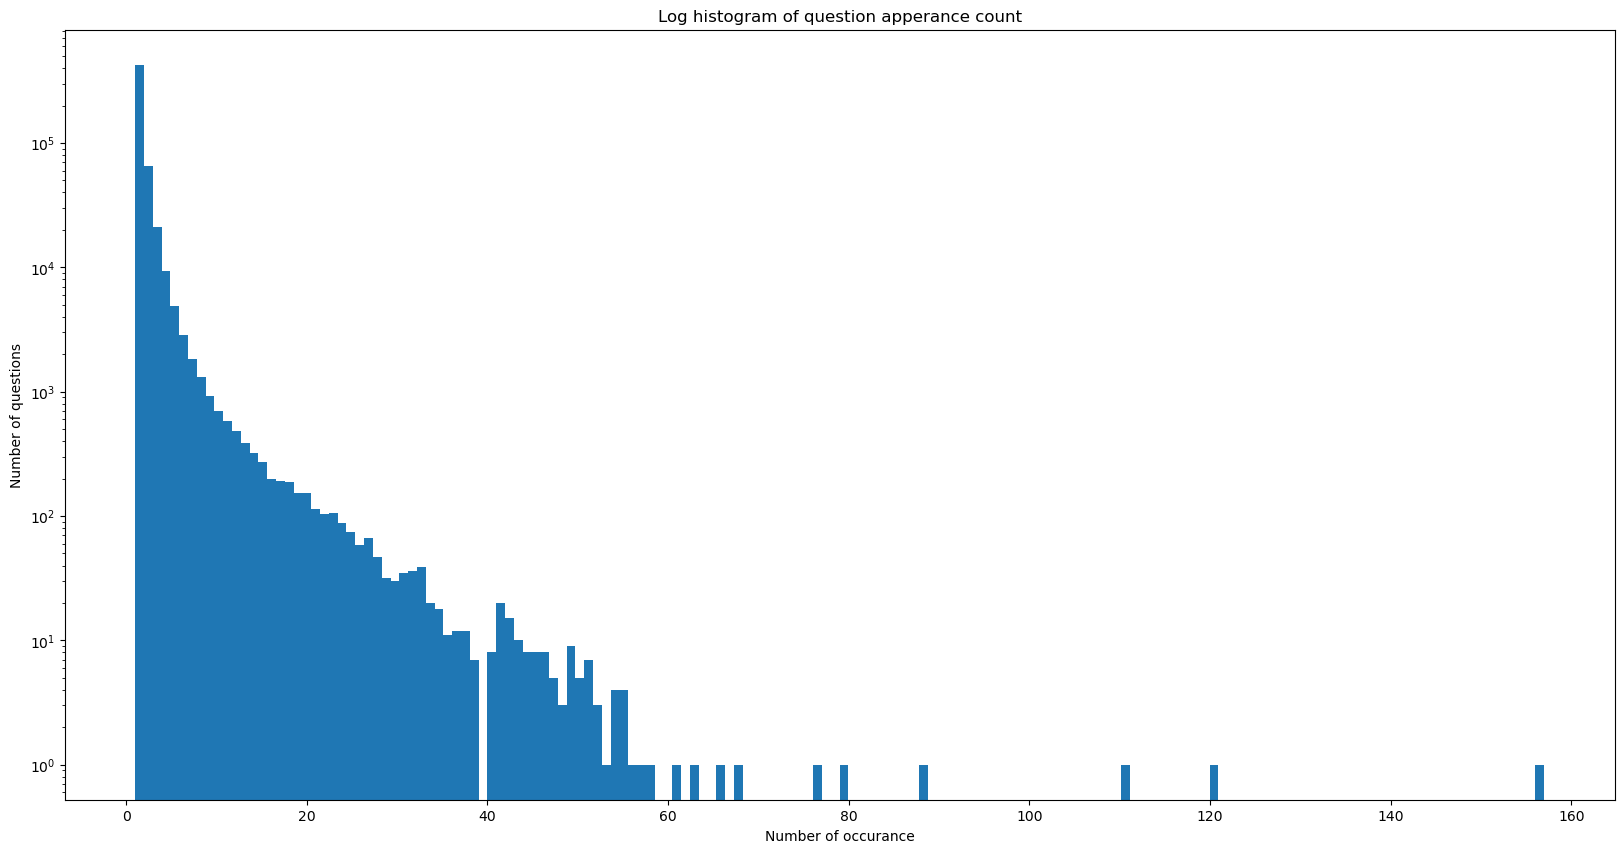

Maximum number of time a question is repeated :  157


In [21]:
plt.figure(figsize=(20,10))
plt.hist(questions_id.value_counts(),bins=160)
plt.title("Log histogram of question apperance count")
plt.xlabel("Number of occurance")
plt.ylabel("Number of questions")
plt.yscale('log')
plt.show()
print("Maximum number of time a question is repeated : ",temp_df.values.max())

In [24]:
missing_data=data[data.isnull().any(axis=1)]
missing_data

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [27]:
data=data.fillna('')
missing_data=data[data.isnull().any(axis=1)]
missing_data

,id,qid1,qid2,question1,question2,is_duplicate


Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [30]:
def create_feature(df):
    df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
    df['q1len']=df['question1'].str.len()
    df['q2len']=df['question2'].str.len()
    df['q1_n_words']=df['question1'].apply(lambda row:len(row.split(" ")))
    df['q2_n_words']=df['question2'].apply(lambda row:len(row.split(" ")))
    def normalize_word_common(row):
        w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
        return 1.0*len(w1 & w2)
    def normalize_word_total(row):
        w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
        return 1.0*(len(w1) +len(w2))
    def normalize_word_share(row):
        w1=set(map(lambda word:word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word:word.lower().strip(),row['question2'].split(" ")))
        return 1.0* len(w1 & w2)/(len(w1) +len(w2))
    df['word_common']=df.apply(normalize_word_common,axis=1)
    df['word_total']=df.apply(normalize_word_total,axis=1)
    df['word_share']=df.apply(normalize_word_share,axis=1)
    df['freq_q1+q2']=df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2']=abs(df['freq_qid1']-df['freq_qid2'])
    
    return df


In [32]:
%%time
data=create_feature(data.copy())

CPU times: user 8.55 s, sys: 78.9 ms, total: 8.62 s
Wall time: 8.66 s


In [33]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [36]:
print("Minimum length of question in question1: ",min(data['q1_n_words']))
print("Minimum length of question in question2: ",min(data['q2_n_words']))
print("Number of question with minimum length (q1) :",data[data['q1_n_words']==1].shape[0])
print("Number of question with minimum length (q2) :",data[data['q2_n_words']==1].shape[0])

Minimum length of question in question1:  1
Minimum length of question in question2:  1
Number of question with minimum length (q1) : 67
Number of question with minimum length (q2) : 24


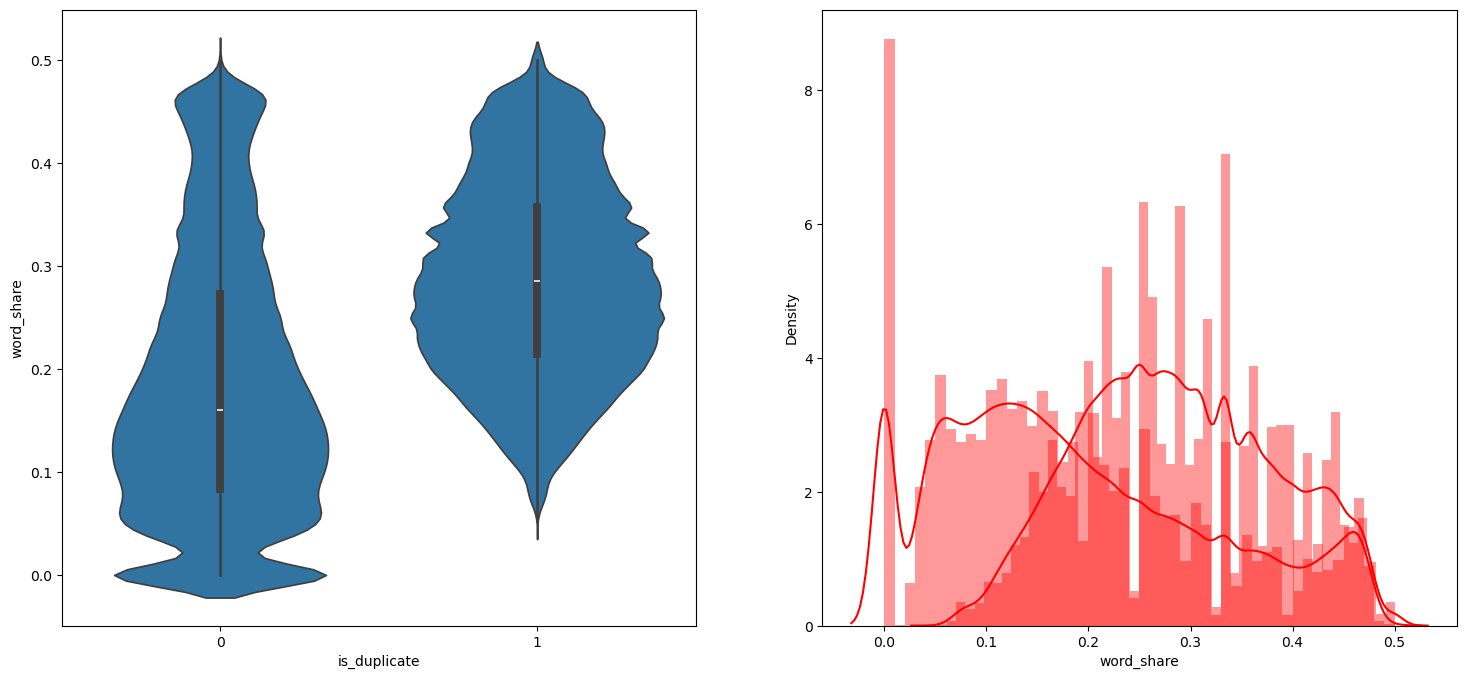

In [38]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=data)
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate']==1.0]['word_share'][0:],label='1',color='red')
sns.distplot(data[data['is_duplicate']==0.0]['word_share'][0:],label='0',color='red')
plt.show()

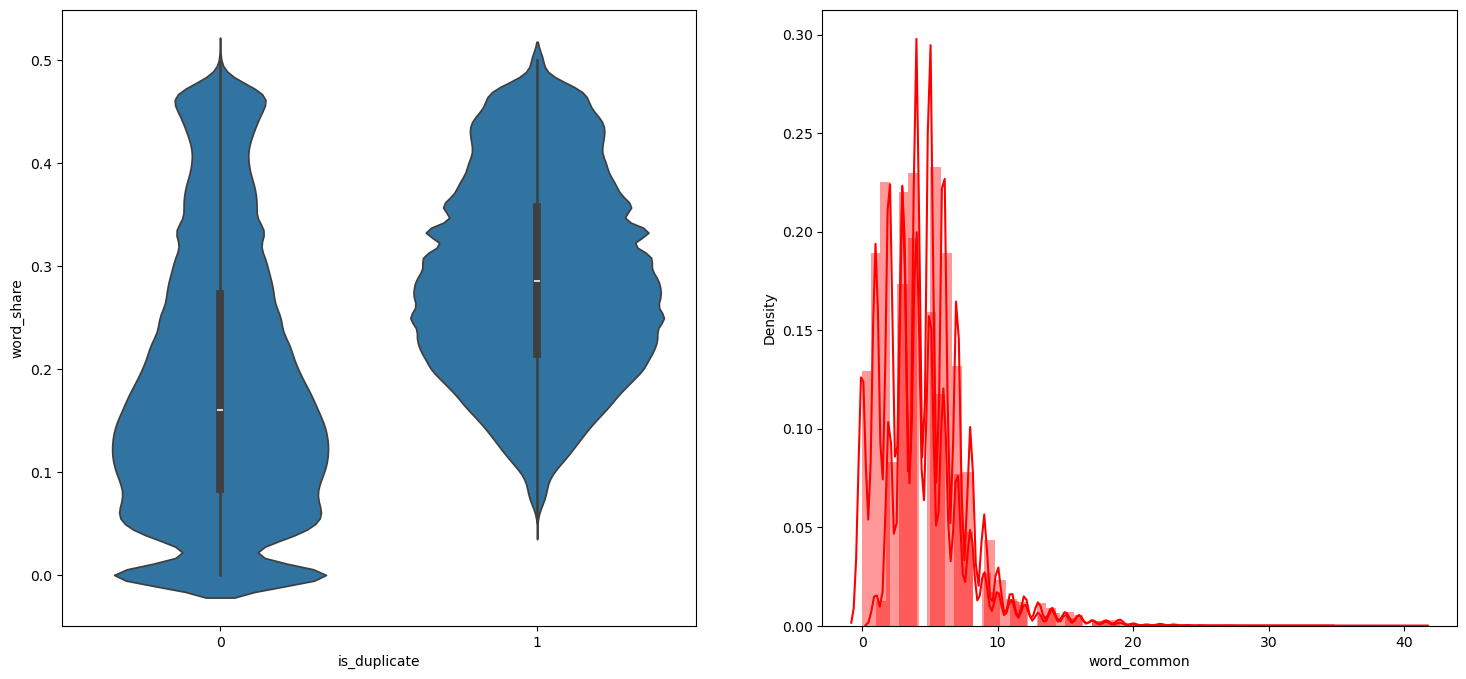

In [39]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=data)
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate']==1.0]['word_common'][0:],label='1',color='red')
sns.distplot(data[data['is_duplicate']==0.0]['word_common'][0:],label='0',color='red')
plt.show()

In [41]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import distance
from fuzzywuzzy import fuzz
from wordcloud import WordCloud,STOPWORDS
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go


In [42]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [45]:
STOP_WORDS= stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile(r'\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if Last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>

In [50]:
SAFE_DIV = 0.0001 
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features


In [52]:
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [54]:
def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [56]:
%%time
data=extract_features(data.copy())

token features...
fuzzy features..
CPU times: user 3min 16s, sys: 777 ms, total: 3min 17s
Wall time: 3min 17s


In [57]:
data.shape

(404290, 32)

In [58]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_common', 'word_total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [59]:
df_duplicate = data[data['is_duplicate'] == 1]
dfp_nonduplicate = data[data['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [60]:
d = os.path.dirname('.')

with open(os.path.join(d, 'train_p.txt'), 'r') as file:
    textp_w = file.read()

with open(os.path.join(d, 'train_n.txt'), 'r') as file:
    textn_w = file.read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


In [61]:
from nltk.corpus import stopwords as nltk_stopwords

# Get the list of stopwords from NLTK and convert to a set
stopwords = set(nltk_stopwords.words('english'))


Word Cloud for Duplicate Question pairs


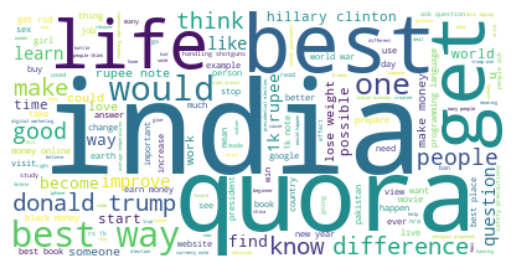

In [62]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


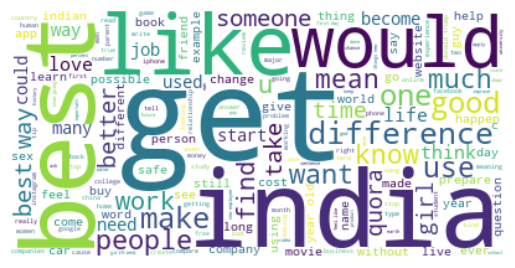

In [63]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<Figure size 1800x1600 with 0 Axes>

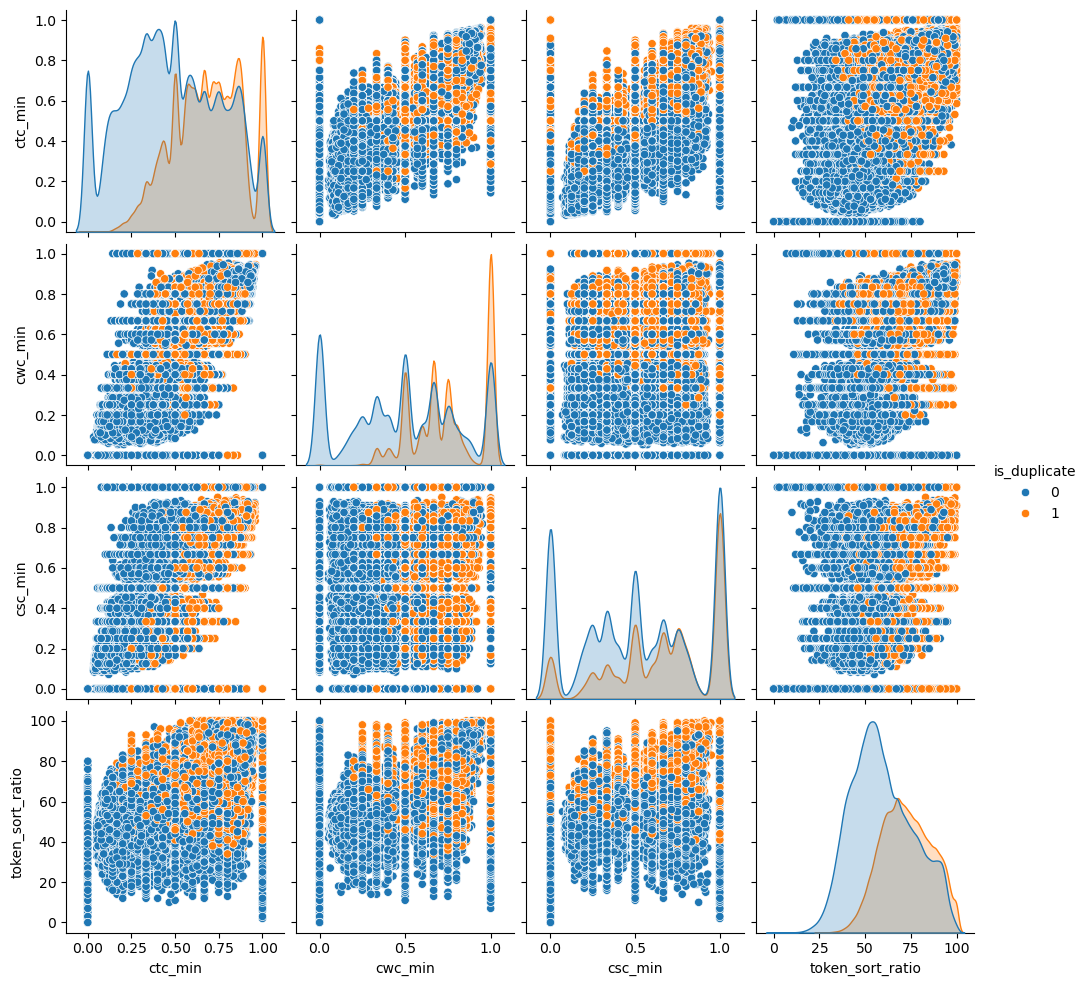

In [64]:
feature_columns=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']
plt.figure(figsize=(18,16))
sns.pairplot(data[feature_columns],hue='is_duplicate',vars=feature_columns[:-1])
plt.show()

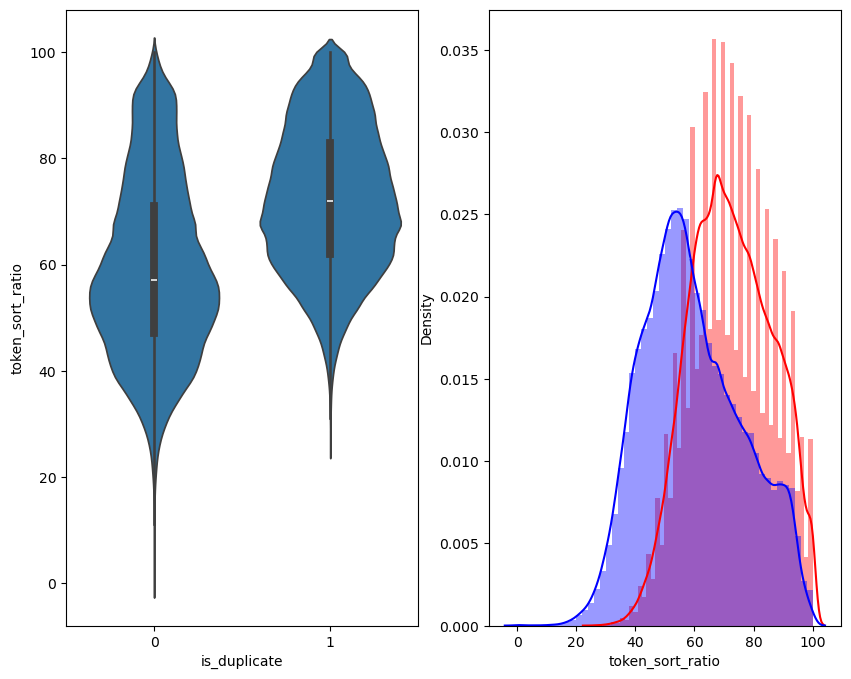

In [65]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = data[0:] , )

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

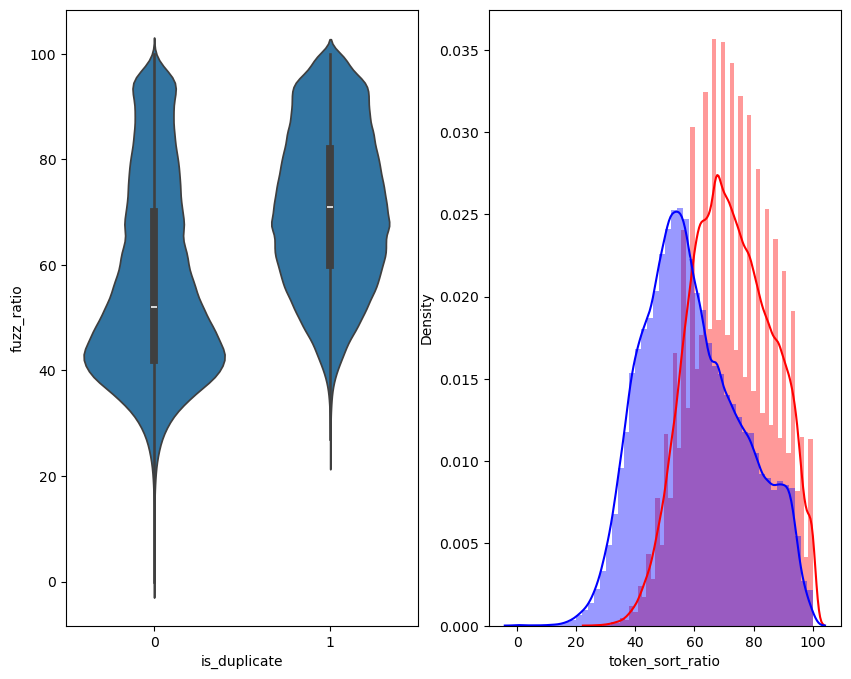

In [66]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = data[0:] , )

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [128]:
dfp_subsampled = data[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [129]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.004s...
[t-SNE] Computed neighbors for 5000 samples in 0.169s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116488
[t-SNE] Computed conditional probabilities in 0.063s
[t-SNE] Iteration 50: error = 85.3775482, gradient norm = 0.0968463 (50 iterations in 0.595s)
[t-SNE] Iteration 100: error = 70.7173920, gradient norm = 0.0136863 (50 iterations in 0.539s)
[t-SNE] Iteration 150: error = 68.6967316, gradient norm = 0.0077935 (50 iterations in 0.520s)
[t-SNE] Iteration 200: error = 67.7432709, gradient norm = 0.0054970 (50 iterations in 0.550s)
[t-SNE] Iteration 250: error = 67.2165375, gradient norm = 0.0041932

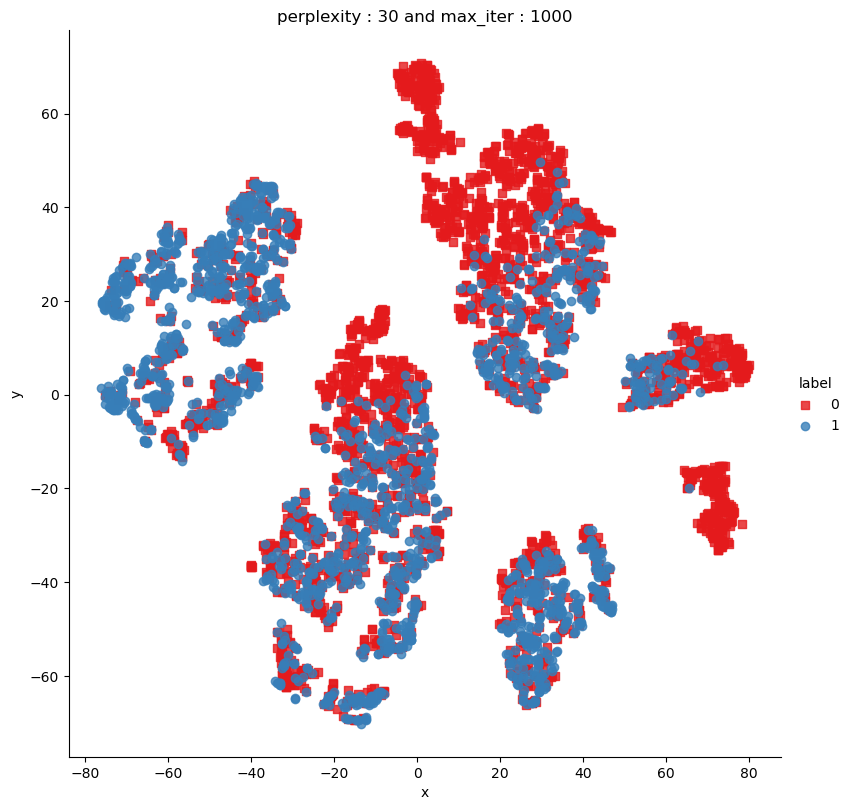

In [130]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, height=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [131]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.002s...
[t-SNE] Computed neighbors for 5000 samples in 0.178s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116488
[t-SNE] Computed conditional probabilities in 0.066s
[t-SNE] Iteration 50: error = 86.3055420, gradient norm = 0.0802323 (50 iterations in 1.132s)
[t-SNE] Iteration 100: error = 69.4754791, gradient norm = 0.0073671 (50 iterations in 0.864s)
[t-SNE] Iteration 150: error = 67.7510529, gradient norm = 0.0037728 (50 iterations in 0.794s)
[t-SNE] Iteration 200: error = 67.1325607, gradient norm = 0.0024693 (50 iterations in 0.794s)
[t-SNE] Iteration 250: error = 66.7930603, gradient norm = 0.0019293

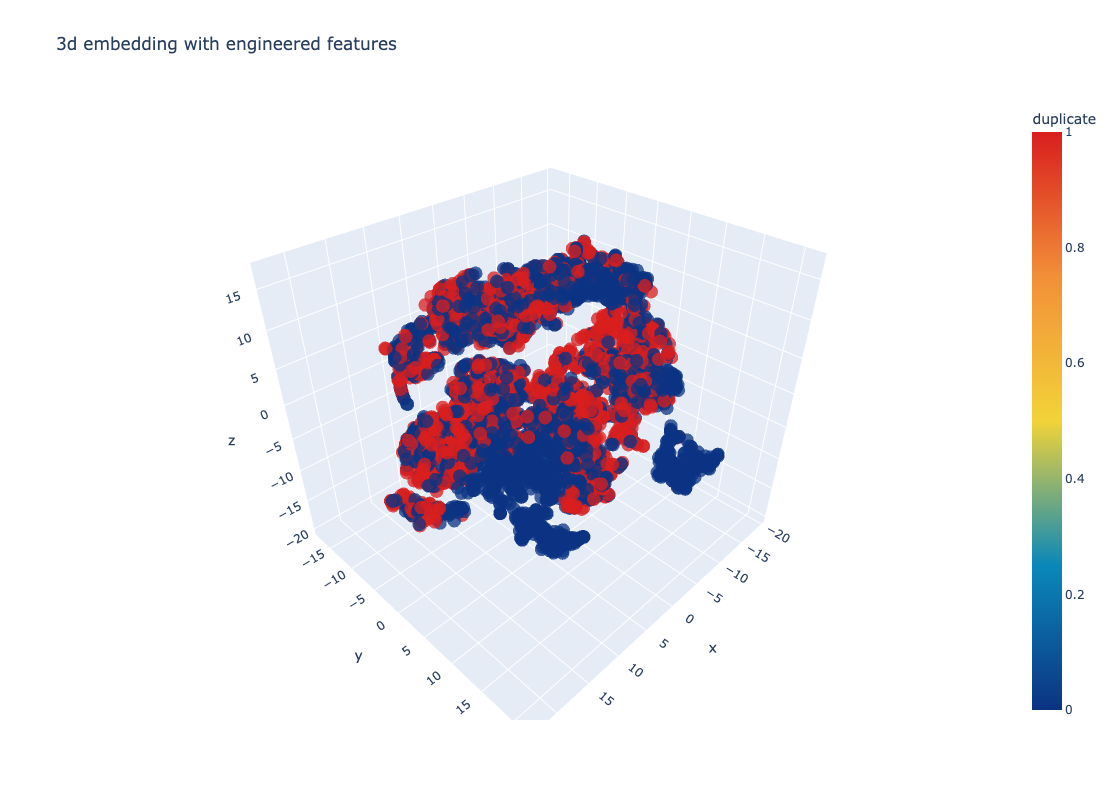

In [132]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')